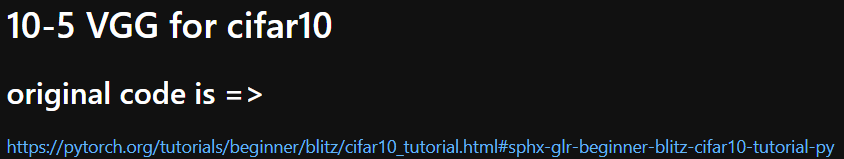

In [4]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [5]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

define loss tracker

In [6]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
            )

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)
trainloder = torch.utils.data.DataLoader(trainset, batch_size=512,
                                         shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#functions to show an image

def imshow(img):
    img = img / 2 * 0.5     #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#get sime random trainig images
dataiter = iter(trainloder)
images, labels = next(iter(trainloder))
vis.images(images/2 + 0.5)

#show images
#imshow(torchvision.util.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 bird  bird horse  frog


make VGG16 using vgg.py

In [11]:
import vgg
#import torchvision.models.vgg as vgg

In [13]:
cfg = [32,32,'M', 64,64,128,128,128,'M',256,256,256,512,512,512,'M'] #13 + 3 =vgg16

In [15]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [16]:
vgg16 = VGG(vgg.make_layers(cfg), 10, True).to(device)

In [17]:
a=torch.Tensor(1, 3, 32, 32).to(device)
out = vgg16(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [18]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9)

lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

make plot

In [19]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(), opts=dict(title='loss tracker', legend=['loss'], showlegend=True))

training

In [20]:
print(len(trainloder))
epochs = 50

for epoch in range(epochs):     #loop over the dataset multiple times
    running_loss = 0.0
    lr_sche.step()
    for i, data in enumerate(trainloder, 0):
        #get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 30 == 29:    #print every 30 mini-batches
            loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloder)]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0

print('Finished Trainig')

98


c:\Users\jys74\anaconda3\envs\PyTorch\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[1,    30] loss: 2.302
[1,    60] loss: 2.299
[1,    90] loss: 2.293
[2,    30] loss: 2.238
[2,    60] loss: 2.139
[2,    90] loss: 2.024
[3,    30] loss: 1.886
[3,    60] loss: 1.825
[3,    90] loss: 1.737
[4,    30] loss: 1.678
[4,    60] loss: 1.622
[4,    90] loss: 1.620
[5,    30] loss: 1.555
[5,    60] loss: 1.496
[5,    90] loss: 1.529
[6,    30] loss: 1.448
[6,    60] loss: 1.415
[6,    90] loss: 1.404
[7,    30] loss: 1.335
[7,    60] loss: 1.300
[7,    90] loss: 1.291
[8,    30] loss: 1.254
[8,    60] loss: 1.230
[8,    90] loss: 1.192
[9,    30] loss: 1.178
[9,    60] loss: 1.159
[9,    90] loss: 1.140
[10,    30] loss: 1.077
[10,    60] loss: 1.052
[10,    90] loss: 1.035
[11,    30] loss: 1.007
[11,    60] loss: 0.988
[11,    90] loss: 0.983
[12,    30] loss: 0.943
[12,    60] loss: 0.975
[12,    90] loss: 0.933
[13,    30] loss: 0.903
[13,    60] loss: 0.872
[13,    90] loss: 0.890
[14,    30] loss: 0.880
[14,    60] loss: 0.844
[14,    90] loss: 0.874
[15,    30] loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


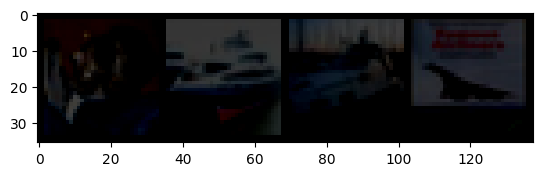

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = next(iter(testloader))

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = vgg16(images.to(device))

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [25]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %
